### General rules:
 * For all figures that you generate, remember to add meaningful labels to the axes, and make a legend, if applicable.
 * Do not hard code constants, like number of samples, number of channels, etc in your program. These values should always be determined from the given data. This way, you can easily use the code to analyse other data sets.
 * Do not use high-level functions from toolboxes like scikit-learn.
 * Replace *Template* by your *FirstnameLastname* in the filename.

# AAND - BCI Exercise Sheet #03

#### Name: Martin Iniguez de Onzono Muruaga


In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import scipy.stats

import bci_minitoolbox as bci

## Exercise 1: Nearest Centroid Classifier (NCC)  (1 point)
Implement the calculation of the nearest centroid classifier (NCC) as a Python function `train_NCC`.  The function should take two arguments, the first being the data matrix $\bf{X}$ where each column is a data point ($\bf{x_k}$), and the second being class labels of the data points. Two output arguments should return the weight vector **`w`** and bias `b`.

In [2]:
def train_NCC(X, y):
    '''
    Synopsis:
        w, b= train_NCC(X, y)
    Arguments:
        X: data matrix (features X samples)
        y: labels with values 0 and 1 (1 x samples)
    Output:
        w: NCC weight vector
        b: bias term
    '''
    mrk_0 = np.where(y < 0.5)
    mrk_1 = np.where(y > 0.5)
    
    mu_0 = np.mean(X[:,mrk_0],axis=2).flatten()
    mu_1 = np.mean(X[:,mrk_1],axis=2).flatten()
    
    w = (mu_1-mu_0)/np.linalg.norm(mu_1-mu_0)
    b = w.T @ (mu_1+mu_0)/2
    
    return  w, b

## Exercise 2: Linear Discriminant Analysis (LDA)  (3 points)
Implement the calculation of the LDA classifier as a Python function `train_LDA`.  The function should take two arguments, the first being the data matrix $\bf{X}$ where each column is a data point ($\bf{x_k}$), and the second being class labels of the data points. Two output arguments should return the weight vector **`w`** and bias `b`.

In [3]:
def train_LDA(X, y):
    '''
    Synopsis:
        w, b= train_LDA(X, y)
    Arguments:
        X: data matrix (features X samples)
        y: labels with values 0 and 1 (1 x samples)
    Output:
        w: LDA weight vector
        b: bias term
    '''
    mrk_0 = np.where(y < 0.5)
    mrk_1 = np.where(y > 0.5)
    
    mu_0 = np.mean(X[:,mrk_0],axis=2).flatten()
    mu_1 = np.mean(X[:,mrk_1],axis=2).flatten()
    
    X_0 = X[:,mrk_0]
    X_0 = X_0.reshape((X_0.shape[0],X_0.shape[2]))
    N_0 = len(X_0)
    X_1 = X[:,mrk_1]
    X_1 = X_1.reshape((X_1.shape[0],X_1.shape[2]))
    N_1 = len(X_1)
    
    cov0 = np.cov(X_0)
    cov1 = np.cov(X_1)
    
    cov = (N_0-1)/(N_0+N_1-1)*cov0 + (N_1-1)/(N_0+N_1-1)*cov1
    
    w = np.linalg.inv(cov)@(mu_1-mu_0)
    b = w.T @ (mu_1+mu_0)/2
    
    return w, b

## Exercises 3: Cross-validation with weighted loss (1 point)
Complete the implementation of `crossvalidation` by writing a loss function `loss_weighted_error` which calculates the weighted loss as explained in the lecture.

In [4]:
def crossvalidation(classifier_fcn, X, y, nFolds=10, verbose=False):
    '''
    Synopsis:
        loss_te, loss_tr= crossvalidation(classifier_fcn, X, y, nFolds=10, verbose=False)
    Arguments:
        classifier_fcn: handle to function that trains classifier as output w, b
        X:              data matrix (features X samples)
        y:              labels with values 0 and 1 (1 x samples)
        nFolds:         number of folds
        verbose:        print validation results or not
    Output:
        loss_te: value of loss function averaged across test data
        loss_tr: value of loss function averaged across training data
    '''
    nDim, nSamples = X.shape
    inter = np.round(np.linspace(0, nSamples, num=nFolds + 1)).astype(int)
    perm = np.random.permutation(nSamples)
    errTr = np.zeros([nFolds, 1])
    errTe = np.zeros([nFolds, 1])

    for ff in range(nFolds):
        idxTe = perm[inter[ff]:inter[ff + 1] + 1]
        idxTr = np.setdiff1d(range(nSamples), idxTe)
        w, b = classifier_fcn(X[:, idxTr], y[idxTr])
        out = w.T.dot(X) - b
        errTe[ff] = loss_weighted_error(out[idxTe], y[idxTe])
        errTr[ff] = loss_weighted_error(out[idxTr], y[idxTr])

    if verbose:
        print('{:5.1f} +/-{:4.1f}  (training:{:5.1f} +/-{:4.1f})  [using {}]'.format(errTe.mean(), errTe.std(),
                                                                                     errTr.mean(), errTr.std(), 
                                                                                     classifier_fcn.__name__))
    return np.mean(errTe), np.mean(errTr)    

In [5]:
def loss_weighted_error(out, y):
    '''
    Synopsis:
        loss= loss_weighted_error( out, y )
    Arguments:
        out:  output of the classifier
        y:    true class labels
    Output:
        loss: weighted error
    '''
    mrk_0 = np.where(y < 0.5)
    mrk_1 = np.where(y > 0.5)
    
    out_0 = out[mrk_0]
    out_1 = out[mrk_1]
    
    err_0 = (len(out_0)-np.sum(out_0<0))/len(out_0)
    err_1 = (len(out_1)-np.sum(out_1>0))/len(out_1)
    

    loss = (err_0 + err_1)/2
    return loss

## Preparation: Load Data

In [6]:
fname = 'erp_hexVPsag.npz'
cnt, fs, clab, mnt, mrk_pos, mrk_class, mrk_className = bci.load_data(fname)

## Exercise 4: Classification of Temporal Features  (2 points)
Extract as temporal features from single channels the epochs of the time interval 0 to 1000 ms. Determine the error of classification with LDA and with NCC on those features using 10-fold cross-validation for each single channel. Display the resulting (test) error rates for all channel as scalp topographies (one for LDA and one for NCC).

In [7]:
ival = [0, 1000]
epos, epos_t = bci.makeepochs(cnt, fs, mrk_pos, ival)   
error_Te_NCC = np.zeros(epos.shape[1])
error_Te_LDA = np.zeros(epos.shape[1])

for i in range(epos.shape[1]):
    X = epos[:,i,:]
    error_Te_NCC[i], _ = crossvalidation(train_NCC, X, mrk_class, nFolds=10, verbose=False) 
    error_Te_LDA[i], _ = crossvalidation(train_LDA, X, mrk_class, nFolds=10, verbose=False)  

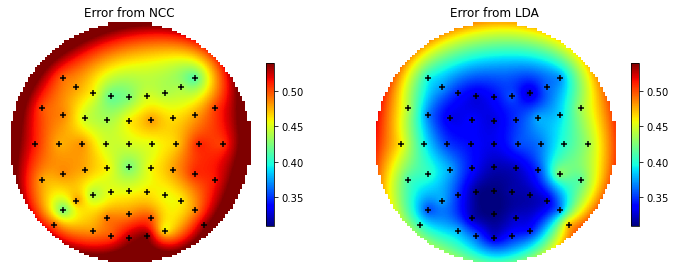

In [8]:
max_repr = np.max(error_Te_NCC)
min_repr = np.min(error_Te_LDA)
fig = plt.figure(figsize=(12,6))

fig.add_subplot(121)
plt.title('Error from NCC')
bci.scalpmap(mnt,error_Te_NCC,[min_repr,max_repr])

fig.add_subplot(122)
plt.title('Error from LDA')
bci.scalpmap(mnt,error_Te_LDA,[min_repr,max_repr])

## Exercise 5: Classification of Spatial Features  (3 points)
Perform classification (*target* vs. *nontarget*) on spatial features (average across time within a 50 ms interval) in a time window that is shifted from 0 to 1000 ms in steps of 10 ms, again with both, LDA and NCC. Visualize the time courses of the classification error. Again, use 10-fold cross-validation. Here, use a baseline correction w.r.t. the prestimulus interval -100 to 0 ms.

In [9]:
val = [0, 1000]
ref_ival = [-100, 0]
epos, epos_t = bci.makeepochs(cnt, fs, mrk_pos, ival)
epos_corr = bci.baseline(epos,epos_t,ref_ival)

error_Te_NCC = np.zeros(epos_t.shape[0]-5)
error_Te_LDA = np.zeros(epos_t.shape[0]-5)

for i in range(len(error_Te_NCC)):
    X = np.mean(epos_corr[i:i+5,:,:],axis=0)
    error_Te_NCC[i], _ = crossvalidation(train_NCC, X, mrk_class, nFolds=10, verbose=False) 
    error_Te_LDA[i], _ = crossvalidation(train_LDA, X, mrk_class, nFolds=10, verbose=False)    

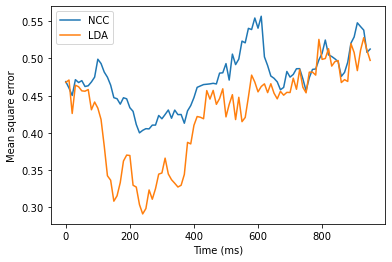

In [10]:
plt.plot(epos_t[0:len(epos_t)-5],error_Te_NCC,label='NCC')
plt.plot(epos_t[0:len(epos_t)-5],error_Te_LDA,label='LDA');
plt.xlabel('Time (ms)')
plt.ylabel('Mean square error');
plt.legend();